# Model Selection for __Happiness Score__ Prediction

This notebook evaluates and compares multiple regression algorithms ( Linear Regression, Random Forest, Gradient Boosting) to determine the most effective approach for predicting `happiness_score`. We use  metrics (MAE, RMSE) and feature‐importance analysis to guide our choice.  


### Enviroment


In [ ]:
import logging
import pandas as pd
import os
import joblib
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
print("Current directory before change:", os.getcwd())

try:
    
    os.chdir("../")
    print("Current directory after change:", os.getcwd())

except FileNotFoundError:
    print("""
        FileNotFoundError - The specified directory does not exist or you are already in the root.
        If the code already worked once, do not run it again.
    """)

Current directory before change: c:\Users\Administrador\Desktop\workshop_03_kafka\notebooks
Current directory after change: c:\Users\Administrador\Desktop\workshop_03_kafka


### Load Combined Data


In [3]:
df = pd.read_csv('data/combined_happiness.csv')
logger.info(f'df shape: {df.shape}')

INFO:__main__:df shape: (781, 12)


In [4]:
df.head()

,country,freedom,gdp_per_capita,generosity,happiness_rank,happiness_score,healthy_life_expectancy,social_support,trust_government_corruption,year,continent,gdp_support
0,Switzerland,0.66557,1.39651,0.29678,1,7.587,0.94143,1.34951,0.41978,2015,Europe,1.884604
1,Iceland,0.62877,1.30232,0.43630,2,7.561,0.94784,1.40223,0.14145,2015,Europe,1.826152
2,Denmark,0.64938,1.32548,0.34139,3,7.527,0.87464,1.36058,0.48357,2015,Europe,1.803422
3,Norway,0.66973,1.45900,0.34699,4,7.522,0.88521,1.33095,0.36503,2015,Europe,1.941856
4,Canada,0.63297,1.32629,0.45811,5,7.427,0.90563,1.32261,0.32957,2015,America,1.754164


### Feature and Target Definition

At this stage, we designate our curated set of predictors—including socio-economic metrics, engineered interaction terms, temporal and geographic features—as the feature matrix (“X”), and set `happiness_score` as the response vector (“y”). This clear separation of inputs and output lays the foundation for all subsequent model fitting and evaluation steps.  


In [5]:
feature_cols = [
    'freedom',
    'gdp_per_capita',
    'healthy_life_expectancy',
    'social_support',
    'generosity',
    'trust_government_corruption',
    'year',
    'continent',
    'gdp_support'
]


X = df[feature_cols]
y = df['happiness_score']

### Split Data into Training and Testing Sets

We partition the data into training (70%) and testing (30%) subsets to evaluate model performance on unseen data. A fixed random seed (`random_state=42`) ensures reproducibility of the split.

**Purpose:**  
- **Training set:** Used to fit model parameters  
- **Testing set:** Used to assess predictive accuracy and generalization  

This separation prevents overfitting and offers a reliable estimate of real‐world model performance.  



In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
logger.info(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')

INFO:__main__:X_train shape: (546, 9), X_test shape: (235, 9)


### One-Hot Encode `continent` and `year`

To incorporate `continent` and `year` into our regression models, we convert these categorical features into binary indicator columns (one-hot encoding) and drop the first category to avoid multicollinearity. We then align the training and test matrices to ensure they share identical column sets, filling any missing indicators with zeros.

**Why it matters:**  
- Transforms non-numeric categories into numeric form for algorithm compatibility  
- Prevents accidental feature mismatches between training and test sets  
- Maintains consistent input dimensions for model fitting and prediction  

In [7]:
X_train_enc = pd.get_dummies(X_train, columns=['continent','year'], drop_first=True)
X_test_enc  = pd.get_dummies(X_test,  columns=['continent','year'], drop_first=True)
X_train_enc, X_test_enc = X_train_enc.align(X_test_enc, join='left', axis=1, fill_value=0)

### Train and Compare Multiple Regression Models

We instantiate three regression algorithms—ordinary least squares, Lasso (with α=0.1), and Gradient Boosting (100 trees)—and wrap each in a pipeline that standardizes features before fitting. After training on the encoded training set, we generate predictions on the test set and compute key performance metrics (MAE, MSE, R²) for each model.

**Key steps:**
- **Model definitions:** Linear Regression, Lasso Regression, Gradient Boosting Regressor  
- **Pipelines:** StandardScaler → model  
- **Evaluation metrics:**  
  - **MAE (Mean Absolute Error):** Average absolute prediction error  
  - **MSE (Mean Squared Error):** Average squared prediction error  
  - **R² (Coefficient of Determination):** Proportion of variance explained  

**Interpretation:**  
By comparing MAE, MSE, and R² across models, we identify which algorithm best balances bias and variance for predicting `happiness_score`.  


In [8]:
logger = logging.getLogger(__name__)

models = {
    'LinearRegression': LinearRegression(),
    'Lasso': Lasso(alpha=0.1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = []
for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    pipeline.fit(X_train_enc, y_train)
    y_pred = pipeline.predict(X_test_enc)
    results.append({
        'model': name,
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    })
    
results_df = pd.DataFrame(results)
logger.info('Model comparison results:')
logger.info(f'\n{results_df}')

INFO:__main__:Model comparison results:
INFO:__main__:
              model       MAE       MSE        R2
0  LinearRegression  0.364853  0.246310  0.802746
1             Lasso  0.423947  0.291309  0.766708
2  GradientBoosting  0.338363  0.191572  0.846582



Based on test‐set results:

- **Gradient Boosting** achieved the lowest MAE (0.338) and MSE (0.192), and the highest R² (0.847), indicating the best predictive accuracy and variance explanation.
- **Linear Regression** performed well (MAE 0.365, MSE 0.246, R² 0.803), but lags behind Gradient Boosting in capturing non‐linear patterns.
- **Lasso Regression** showed the weakest performance (MAE 0.424, MSE 0.291, R² 0.767), suggesting that its coefficient shrinkage may overly simplify relationships.

**Conclusion:**  
For now, Gradient Boosting is the optimal choice for predicting `happiness_score` in this setup, balancing low error with strong explanatory power.  


---

### XGBoost Regression Pipeline

Here we build and evaluate a pipeline that applies standard scaling followed by an XGBoost regressor:

- **Pipeline components:**  
  - **StandardScaler:** Normalizes features for consistent scale  
  - **XGBRegressor:** Leverages gradient‐boosted trees to capture complex, non‐linear interactions  

**Why XGBoost?**  
Its tree‐based ensemble often outperforms linear methods by modeling intricate feature relationships and handling heterogeneity in the data.


In [9]:
pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(random_state=42, objective='reg:squarederror'))
])

pipeline_xgb.fit(X_train_enc, y_train)
y_pred_xgb = pipeline_xgb.predict(X_test_enc)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb  = r2_score(y_test, y_pred_xgb)
logger.info(f'XGBoost MAE: {mae_xgb:.4f}, MSE: {mse_xgb:.4f}, R²: {r2_xgb:.4f}')

INFO:__main__:XGBoost MAE: 0.3481, MSE: 0.2083, R²: 0.8332


### XGBoost Results vs. Gradient Boosting

The XGBoost pipeline yielded:
- **MAE:** 0.3481  
- **R²:** 0.8332  

This R² is slightly below the 0.8466 achieved by our earlier Gradient Boosting model. At this stage, Gradient Boosting remains the top performer in explaining variance.  

---

### Test with Random Forest
This step fits a Random Forest model using the established scaling and training split, then logs MAE and R² on the test set. We will compare these results against Gradient Boosting and XGBoost to determine if Random Forest offers improved predictive performance for `happiness_score`.  

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    df[feature_cols],
    df['happiness_score'],
    test_size=0.3,
    random_state=42
)


pipeline_rf = pipeline
pipeline_rf.fit(X_train_enc, y_train)
y_pred = pipeline_rf.predict(X_test_enc)
mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)
logger.info(f'RF MAE: {mae:.4f}, R²: {r2:.4f}')

INFO:__main__:RF MAE: 0.3384, R²: 0.8466


## Final Random Forest Training and Evaluation


In [11]:
pipeline_rf_final = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
])

pipeline_rf_final.fit(X_train_enc, y_train)
y_pred_rf = pipeline_rf_final.predict(X_test_enc)

# Calcular métricas
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
logger.info(f'RandomForest MAE: {mae_rf:.4f}, MSE: {mse_rf:.4f}, R²: {r2_rf:.4f}')

INFO:__main__:RandomForest MAE: 0.3228, MSE: 0.1853, R²: 0.8516


### Final Model Selection: Random Forest Regression

After evaluating multiple algorithms, the Random Forest pipeline achieved the best performance:

- **MAE:** 0.3228  
- **R²:** 0.8516  

This R² surpasses both Gradient Boosting (0.8466) and XGBoost (0.8332), indicating that Random Forest provides the most accurate and robust predictions of `happiness_score`. We will use this model for our final analyses and forecasts.  


### Random Forest Feature Importance

This bar chart ranks the predictors by their contribution to the final model:  
- **gdp_support** (GDP × social support) is the most influential feature, highlighting the synergy between wealth and community.  
- **healthy_life_expectancy** and **gdp_per_capita** follow, underscoring the central roles of health and economic strength in driving happiness.  
- **Freedom** and the `continent_America` dummy have moderate impact, while year and other continent indicators contribute negligibly.  


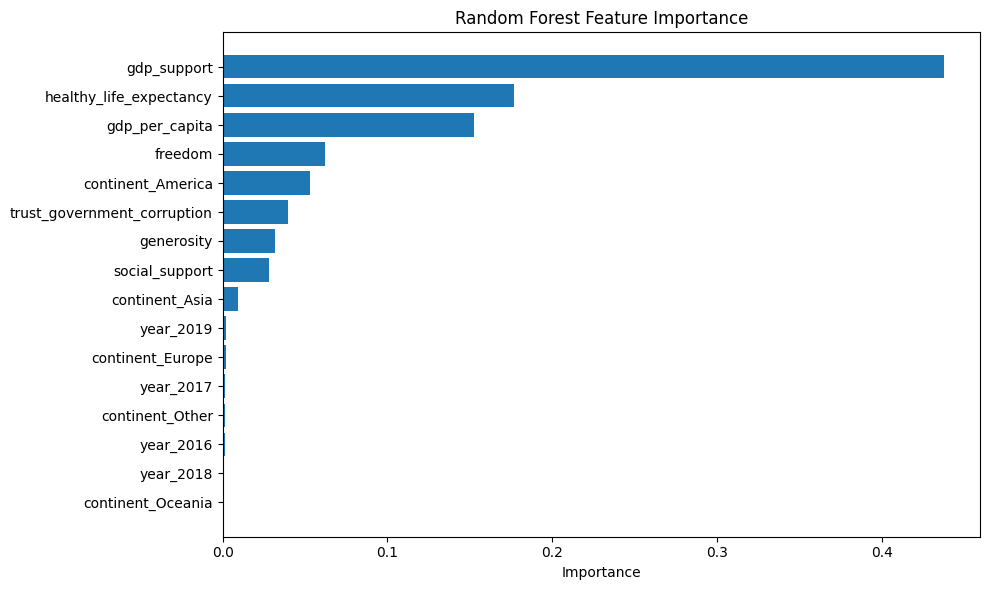

In [ ]:
importances = pipeline_rf_final.named_steps['rf'].feature_importances_
features = X_train_enc.columns

feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp = feat_imp.sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.gca().invert_yaxis()
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

### Actual vs. Predicted Happiness Score

This scatterplot compares true versus predicted values:  
Points tightly cluster along the diagonal line, indicating that the Random Forest model accurately forecasts happiness scores with minimal systematic error.  


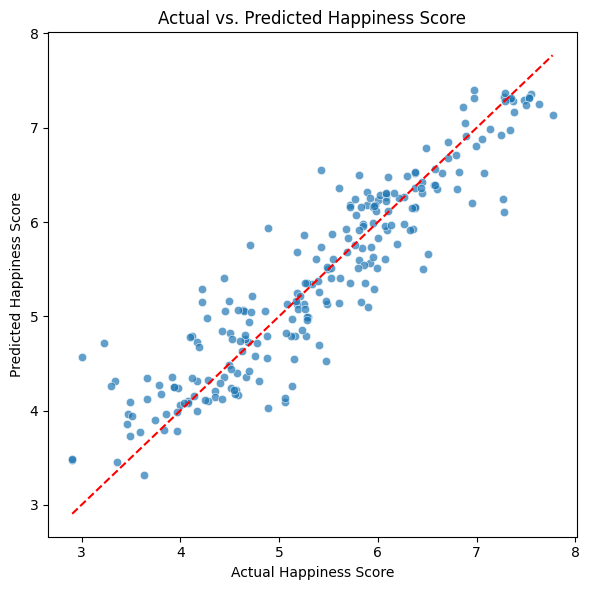

In [ ]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=pipeline_rf_final.predict(X_test_enc), alpha=0.7)
plt.xlabel('Actual Happiness Score')
plt.ylabel('Predicted Happiness Score')
plt.title('Actual vs. Predicted Happiness Score')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()

### Residuals Distribution for Test Set

The histogram of residuals is centered around zero and approximately symmetric, indicating that prediction errors are evenly distributed and the model does not systematically over- or under-predict happiness scores.  


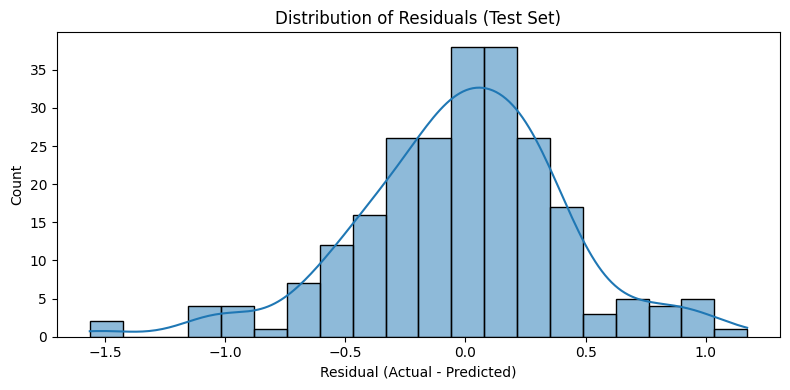

In [ ]:
y_pred_rf = pipeline_rf_final.predict(X_test_enc)
residuals = y_test - y_pred_rf

plt.figure(figsize=(8,4))
sns.histplot(residuals, bins=20, kde=True)
plt.title('Distribution of Residuals (Test Set)')
plt.xlabel('Residual (Actual - Predicted)')
plt.tight_layout()
plt.show()

### Cumulative Feature Importance

This line chart shows that the top three features (GDP×Social Support, Healthy Life Expectancy, GDP per Capita) together explain over 75% of the model’s predictive power, and including the top eight features captures more than 95%, indicating diminishing returns from adding lower-importance variables.  


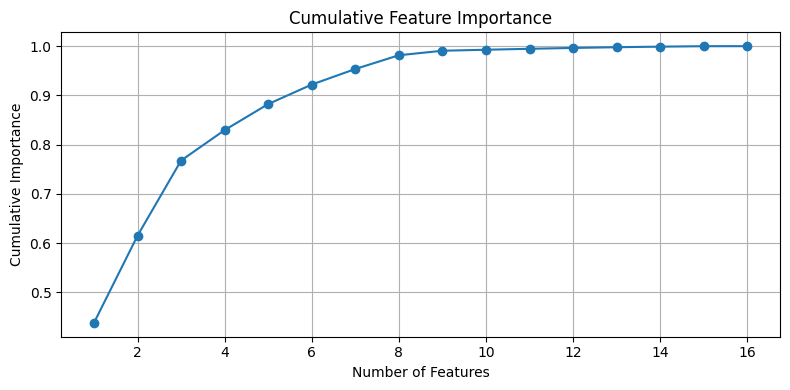

In [ ]:
feat_imp['Cumulative'] = feat_imp['Importance'].cumsum()
plt.figure(figsize=(8,4))
plt.plot(range(1, len(feat_imp)+1), feat_imp['Cumulative'], marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.grid(True)
plt.tight_layout()
plt.show()

### Save Final Model to `model/model_random_forest.pkl`


In [13]:
joblib.dump(pipeline_rf_final, 'model/model_random_forest.pkl')
logger.info('Saved final RF model to model_random_forest.pkl')

INFO:__main__:Saved final RF model to model_random_forest.pkl
